# Data visualization

In [1]:
import csv 
import io
import pyspark
import pandas as pd
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import ast
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark_dist_explore import hist

In [2]:
spark = SparkSession.builder \
.master('local[*]') \
.config("spark.driver.memory", "15g") \
.appName('My App') \
.getOrCreate()

Load units

In [3]:
df=pd.read_csv('data_full_encoded_units.csv', index_col=0).reset_index()

/usr/lib/python3/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df_schema = StructType([StructField("index", StringType(), True),
                        StructField("levels", IntegerType(), True),
                        StructField("units_lst", StringType(), True)])

dfs = spark.createDataFrame(df, schema=df_schema)

In [5]:
dfs.printSchema()

root
 |-- index: string (nullable = true)
 |-- levels: integer (nullable = true)
 |-- units_lst: string (nullable = true)



In [6]:
dfs.show(10)

+-----+------+---------+
|index|levels|units_lst|
+-----+------+---------+
|    0|     2|  Nidalee|
|    0|     2|    Teemo|
|    0|     2|   Irelia|
|    0|     2|    Yuumi|
|    0|     2|     Jinx|
|    0|     2| Katarina|
|    0|     2|  Sejuani|
|    0|     2|     Shen|
|    0|     2|     Azir|
|    1|     2|    Elise|
+-----+------+---------+
only showing top 10 rows



In [7]:
df_pivot=dfs.groupBy("index").pivot("units_lst").sum("levels")

In [8]:
df_pivot.printSchema()

root
 |-- index: string (nullable = true)
 |-- Aatrox: long (nullable = true)
 |-- Ahri: long (nullable = true)
 |-- Akali: long (nullable = true)
 |-- Annie: long (nullable = true)
 |-- Aphelios: long (nullable = true)
 |-- Ashe: long (nullable = true)
 |-- Azir: long (nullable = true)
 |-- Cassiopeia: long (nullable = true)
 |-- Diana: long (nullable = true)
 |-- Elise: long (nullable = true)
 |-- Evelynn: long (nullable = true)
 |-- Ezreal: long (nullable = true)
 |-- Fiora: long (nullable = true)
 |-- Garen: long (nullable = true)
 |-- Hecarim: long (nullable = true)
 |-- Irelia: long (nullable = true)
 |-- Janna: long (nullable = true)
 |-- JarvanIV: long (nullable = true)
 |-- Jax: long (nullable = true)
 |-- Jhin: long (nullable = true)
 |-- Jinx: long (nullable = true)
 |-- Kalista: long (nullable = true)
 |-- Katarina: long (nullable = true)
 |-- Kayn: long (nullable = true)
 |-- Kennen: long (nullable = true)
 |-- Kindred: long (nullable = true)
 |-- LeeSin: long (nullable = 

In [20]:
len(df_pivot.columns)-2

58

Load traits

In [10]:
df=pd.read_csv('data_full_encoded_traits.csv', index_col=0).reset_index()

df_schema = StructType([StructField("index", StringType(), True),
                        StructField("traits_level", IntegerType(), True),
                        StructField("traits_lst", StringType(), True)])

dfs = spark.createDataFrame(df, schema=df_schema)

df_pivot2=dfs.groupBy("index").pivot("traits_lst").sum("traits_level")

df_pivot2.printSchema()

root
 |-- index: string (nullable = true)
 |-- Adept: long (nullable = true)
 |-- Assassin: long (nullable = true)
 |-- Boss: long (nullable = true)
 |-- Brawler: long (nullable = true)
 |-- Cultist: long (nullable = true)
 |-- Dazzler: long (nullable = true)
 |-- Divine: long (nullable = true)
 |-- Duelist: long (nullable = true)
 |-- Dusk: long (nullable = true)
 |-- Elderwood: long (nullable = true)
 |-- Emperor: long (nullable = true)
 |-- Enlightened: long (nullable = true)
 |-- Exile: long (nullable = true)
 |-- Fortune: long (nullable = true)
 |-- Hunter: long (nullable = true)
 |-- Keeper: long (nullable = true)
 |-- Mage: long (nullable = true)
 |-- Moonlight: long (nullable = true)
 |-- Mystic: long (nullable = true)
 |-- NaN: long (nullable = true)
 |-- Ninja: long (nullable = true)
 |-- Shade: long (nullable = true)
 |-- Sharpshooter: long (nullable = true)
 |-- Spirit: long (nullable = true)
 |-- Tormented: long (nullable = true)
 |-- Vanguard: long (nullable = true)
 |-- 

In [21]:
len(df_pivot2.columns)-2

26

Load data

In [12]:
data=pd.read_csv('data_modificato.csv', index_col=0).reset_index()

In [13]:
df_schema = StructType([StructField("index", StringType(), True),
                        StructField("patch_version", StringType(), True),
                        StructField("match_id", StringType(), True),
                        StructField("puuid", StringType(), True),
                        StructField("placement", IntegerType(), True),
                        StructField("level", IntegerType(), True),
                        StructField("gold_left", IntegerType(), True),
                        StructField("last_round", IntegerType(), True),
                        StructField("time_in_game", FloatType(), True),
                        StructField("total_dmg_to_players", IntegerType(), True),
                        StructField("players_eliminated", IntegerType(), True),
                        StructField("chosen_unit", StringType(), True),
                        StructField("chosen_trait", StringType(), True),
                        StructField("units", StringType(), True),
                        StructField("traits", StringType(), True),
                        StructField("units_lst", StringType(), True),
                        StructField("levels", StringType(), True),
                        StructField("traits_lst", StringType(), True),
                        StructField("traits_level", StringType(), True)])

data_spark = spark.createDataFrame(data, schema=df_schema)

In [14]:
data_spark=data_spark.drop('units', 'traits', 'units_lst', 'levels', 'traits_lst', 'traits_level')

Merge datasets

In [15]:
data_final=data_spark.join(df_pivot, on='index')
data_final=data_final.join(df_pivot2, on='index')

In [22]:
data_final.printSchema()

root
 |-- index: string (nullable = true)
 |-- patch_version: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- puuid: string (nullable = true)
 |-- placement: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- gold_left: integer (nullable = true)
 |-- last_round: integer (nullable = true)
 |-- time_in_game: float (nullable = true)
 |-- total_dmg_to_players: integer (nullable = true)
 |-- players_eliminated: integer (nullable = true)
 |-- chosen_unit: string (nullable = true)
 |-- chosen_trait: string (nullable = true)
 |-- Aatrox: long (nullable = true)
 |-- Ahri: long (nullable = true)
 |-- Akali: long (nullable = true)
 |-- Annie: long (nullable = true)
 |-- Aphelios: long (nullable = true)
 |-- Ashe: long (nullable = true)
 |-- Azir: long (nullable = true)
 |-- Cassiopeia: long (nullable = true)
 |-- Diana: long (nullable = true)
 |-- Elise: long (nullable = true)
 |-- Evelynn: long (nullable = true)
 |-- Ezreal: long (nullable = true)
 |-- Fio

In [23]:
len(data_final.columns)-3

96

In [17]:
data_final = data_final.filter((data_final.patch_version != '11.10') & (data_final.patch_version != '10.19'))

## Plots

In [25]:
import matplotlib.pyplot as plt

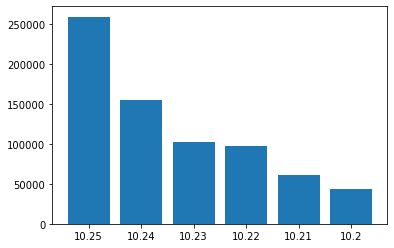

In [29]:
patch=data[~data.patch_version.isin([10.19, 11.10])].patch_version.value_counts().reset_index()
plt.bar(patch['index'].apply(str), patch.patch_version)
plt.show()

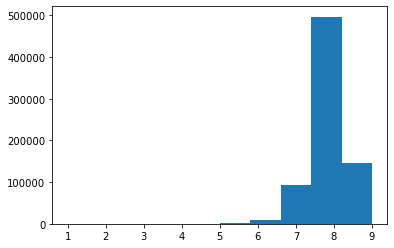

In [56]:
plt.hist(data.level)
plt.show()

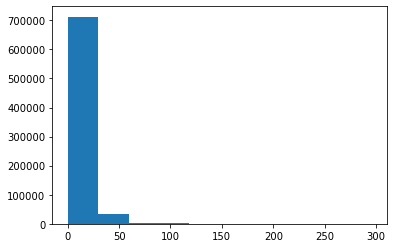

In [57]:
plt.hist(data.gold_left)
plt.show()

[]

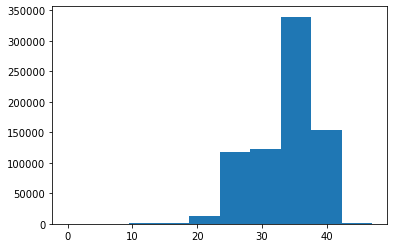

In [58]:
plt.hist(data.last_round)
plt.plot()

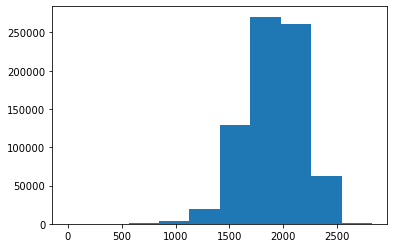

In [59]:
plt.hist(data.time_in_game)
plt.show()

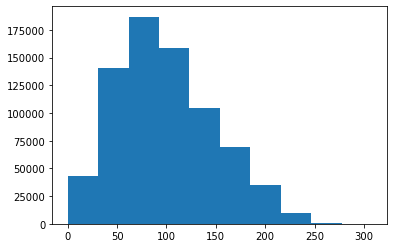

In [60]:
plt.hist(data.total_dmg_to_players)
plt.show()

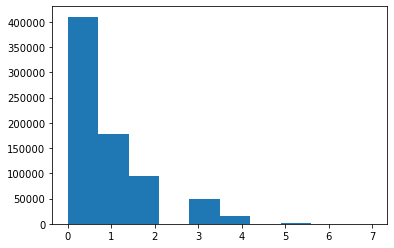

In [61]:
plt.hist(data.players_eliminated)
plt.show()

In [62]:
data.corr()

,index,patch_version,placement,level,gold_left,last_round,time_in_game,total_dmg_to_players,players_eliminated
index,1.000000,3.510357e-01,1.059815e-05,0.063842,0.000815,-0.080439,-0.144209,-0.001795,0.000823
patch_version,0.351036,1.000000e+00,6.455860e-15,0.013258,-0.003766,-0.027237,-0.052675,-0.000543,0.000266
placement,0.000011,6.455860e-15,1.000000e+00,-0.535271,0.076248,-0.872941,-0.837772,-0.894784,-0.714768
level,0.063842,1.325779e-02,-5.352714e-01,1.000000,-0.260532,0.605286,0.588753,0.579344,0.371028
gold_left,0.000815,-3.766466e-03,7.624828e-02,-0.260532,1.000000,-0.168392,-0.171942,-0.090884,-0.026646
last_round,-0.080439,-2.723650e-02,-8.729407e-01,0.605286,-0.168392,1.000000,0.976319,0.866586,0.605877
time_in_game,-0.144209,-5.267529e-02,-8.377722e-01,0.588753,-0.171942,0.976319,1.000000,0.831245,0.575422
total_dmg_to_players,-0.001795,-5.433762e-04,-8.947837e-01,0.579344,-0.090884,0.866586,0.831245,1.000000,0.732289
players_eliminated,0.000823,2.657394e-04,-7.147680e-01,0.371028,-0.026646,0.605877,0.575422,0.732289,1.000000


In [26]:
data_final=data_final.drop('NaN')

In [27]:
data_final_clean = data_final.fillna(float(0))

In [28]:
data_final_clean = data_final_clean.na.fill(value=0)

(array([1.3077e+04, 2.8868e+04, 5.8800e+04, 7.7196e+04, 8.7232e+04,
        9.4270e+04, 8.0857e+04, 7.3572e+04, 5.5970e+04, 4.5139e+04,
        3.8470e+04, 2.8713e+04, 2.1778e+04, 1.2249e+04, 6.2980e+03,
        2.6460e+03, 7.8300e+02, 2.4900e+02, 5.9000e+01, 6.0000e+00]),
 array([  0. ,  15.4,  30.8,  46.2,  61.6,  77. ,  92.4, 107.8, 123.2,
        138.6, 154. , 169.4, 184.8, 200.2, 215.6, 231. , 246.4, 261.8,
        277.2, 292.6, 308. ]),
 <a list of 20 Patch objects>)

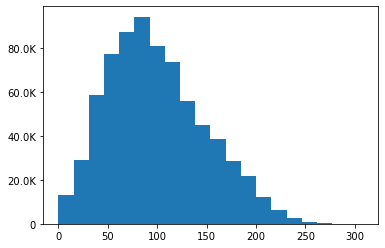

In [30]:
fig, ax = plt.subplots()
hist(ax, data_final.select('total_dmg_to_players'), bins = 20)

(array([154100.,  90683.,    217.]),
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <a list of 3 Patch objects>)

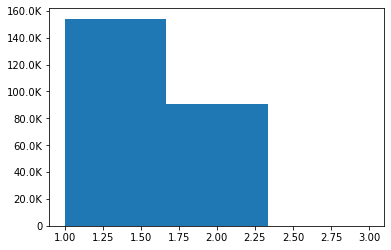

In [33]:
fig, ax = plt.subplots()
hist(ax, data_final.select('Yone'), bins = 3)

(array([1.4637e+05, 7.2126e+04, 1.3800e+02]),
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <a list of 3 Patch objects>)

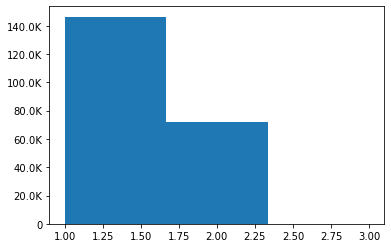

In [34]:
fig, ax = plt.subplots()
hist(ax, data_final.select('Azir'), bins = 3)

(array([1.53715e+05, 7.79950e+04, 5.80000e+01]),
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <a list of 3 Patch objects>)

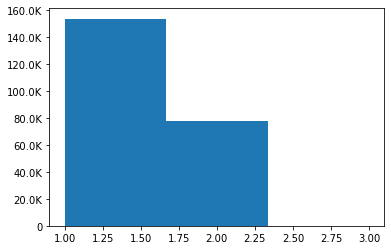

In [35]:
fig, ax = plt.subplots()
hist(ax, data_final.select('Zilean'), bins = 3)

(array([7.9659e+04, 9.1742e+04, 4.3370e+03, 2.4364e+04, 1.2750e+03,
        6.5280e+03, 8.2000e+01, 1.0000e+00]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <a list of 8 Patch objects>)

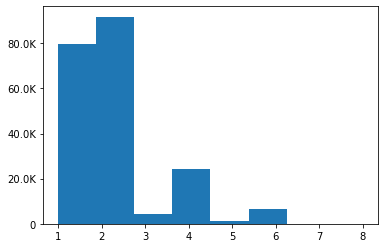

In [37]:
fig, ax = plt.subplots()
hist(ax, data_final.select('Assassin'), bins = 8)

(array([332365.,   4882.,   1239.,  33475.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <a list of 4 Patch objects>)

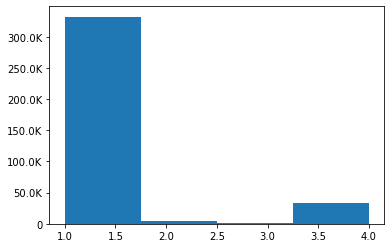

In [39]:
fig, ax = plt.subplots()
hist(ax, data_final.select('Ninja'), bins = 4)

ValueError: Column patch_version has a non-numeric type (StringType), only numeric types are supported

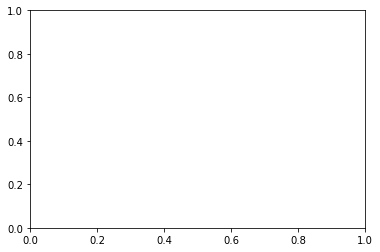

In [26]:
fig, ax = plt.subplots()
hist(ax, data_final.select('patch_version'), bins = 6)